# How to simulate a planetary transit in your lightcurve

One of the K2 mission's primary goals is to discover and study exoplanets around stars in our neighborhood.  In order to discover a planet, it's important to determine our sensitivity to different types of planets around our stars of interest given noise in Kepler and K2 data (sawtooth patterns, rolling band, and even astrophysical artifacts such as stellar rotation and flares). This injection and recovery tool (built upon Laura Kreidberg's `batman` transit simulation package) makes it easy to simulate a planet of any type and add it to a Kepler, K2, or TESS light curve of your choice.

Let's import lightkurve and some necessary packages.

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from lightkurve import KeplerTargetPixelFile

Let's also import this new injection and recovery tool:

In [2]:
import lightkurve.injection as inj

We're going to use the Kepler lightcurve of a G-type star. We'll first download the target pixel file using the `.from_archive` method, and plot the TPF.

/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/lightkurve-1.1.dev0-py3.7.egg/lightkurve/targetpixelfile.py:797: LightkurveWarning: `TargetPixelFile.from_archive` is deprecated and will be removed soon, please use `lightkurve.search_targetpixelfile()` instead.
  LightkurveWarning)


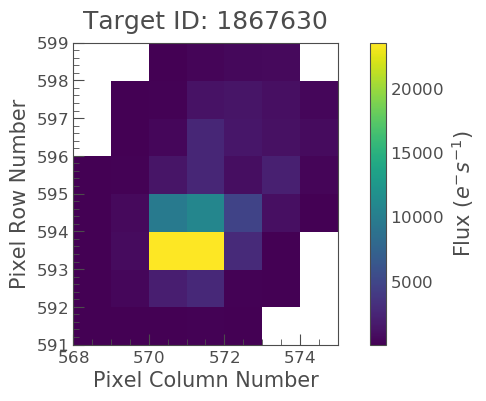

In [5]:
tpf_star = KeplerTargetPixelFile.from_archive(1867630, quarter=1)
tpf.plot()

From our TPF, let's create a lightcurve of this G-type star and plot it.

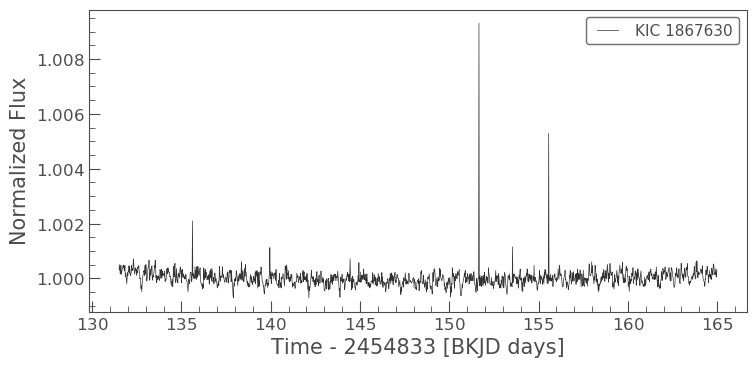

In [13]:
lc_star = tpf_star.to_lightcurve(aperture_mask='all')
lc_star.plot()

We're going to remove nans and outliers and detrend the light curve using the `.flatten` method.  We're also going to normalize the lightcurve.  

It's important to normalize the lightcurve first because the `.inject` method we're going to use later injects a normalized transit model.

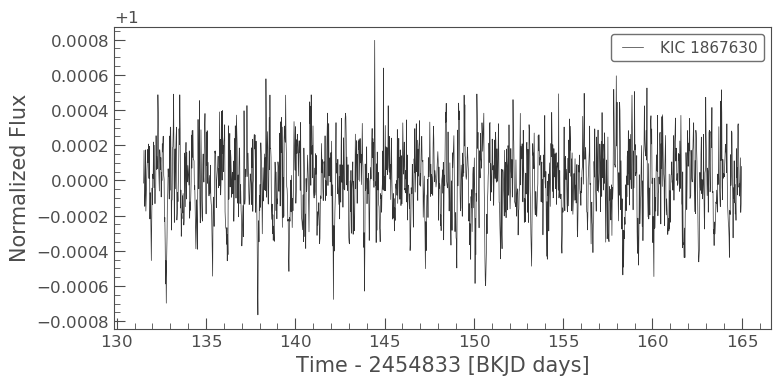

In [14]:
lc_star = lc_star.remove_nans().remove_outliers()
lc_star = lc_star.normalize().flatten()

lc_star.plot()

Now let's create a transit model using the `inj.TransitModel` class.  

A `TransitModel` object is a model of a flat light curve with a specified planetary transit. It is not actally an evaluated light curve, but rather a set of attributes that specify a transiting planet. (You can add as many planets as you want using the `.add_planet` method multiple times, but here we're just going to simulate one planet.)

We're going to create a `TransitModel` object with a planet that has an orbital period of 12 days, a radius of 0.08 stellar radii (approximately Neptune size), and an inclination of 89 degrees. 

In [15]:
model = inj.TransitModel()
model.add_planet(period=9, rprs=0.08, T0=133., inc=88.5)

The `TransitModel` object isn't an evaluated light curve, but you can evaluate and plot it with any time array using the `.evaluate` method. This method returns the flux array of the evaluated model.

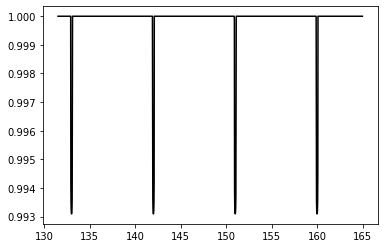

In [17]:
model_flux = model.evaluate(lc_star.time)
plt.plot(lc_star.time, model_flux, color='k')

We can inject this transit model into the star's light curve, simulating a transiting planet around this star, using the `.inject` method. Let's do that and plot the injected light curve.

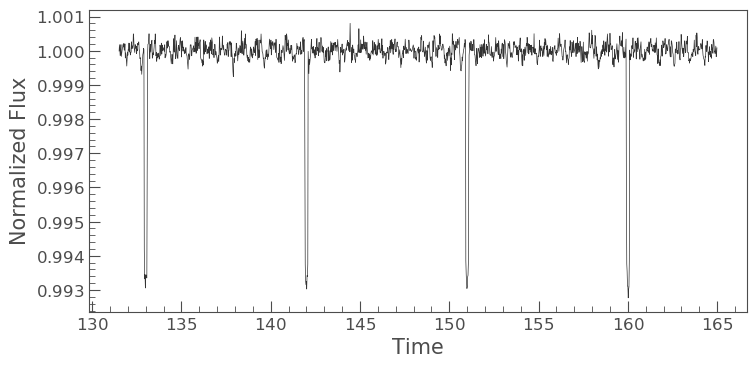

In [18]:
lcinj = lc_star.inject(model)
lcinj.plot()

Hooray! We have a simulated planetary transit.

This tool also supports injection of random parameters from uniform or Gaussian distributions using the `UniformDistribution` and `GaussianDistribution` classes in `lightkurve.injection`.  To inject a random value for a certain parameter (for example, orbital period), just specify that parameter as a Distribution class object.

In [19]:
model = inj.TransitModel()
model.add_planet(period=inj.UniformDistribution(5, 8), 
                 rprs=inj.GaussianDistribution(0.07, 0.01))

In [20]:
model.period

7.9167931280516495

In [21]:
model.rprs

0.07295591870340663

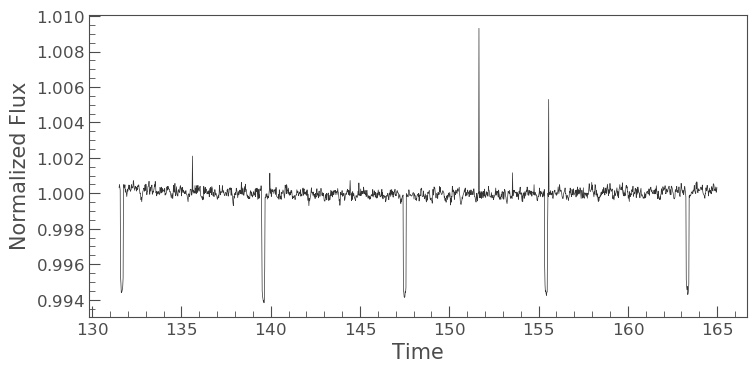

In [22]:
lc_random = lc.inject(model)
lc_random.plot()

Every time you reinitialize the model, a different value will be generated.

In [27]:
model = inj.TransitModel()
model.add_planet(period=inj.UniformDistribution(5,8), 
                 rprs=inj.GaussianDistribution(0.07, 0.01))

In [28]:
model.period

7.547440523258951

In [29]:
model.rprs

0.04491109279910631

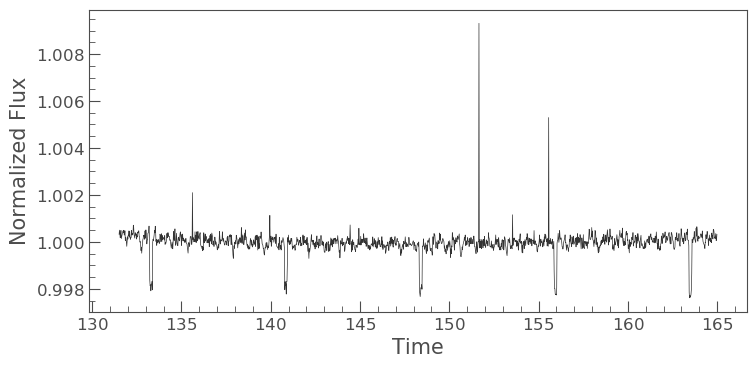

In [30]:
lc_random = lc.inject(model)
lc_random.plot()

So, what now? Usually we'll want to fit the injected transit to study how well we can recover synthetic signals. Let's do that now. 

# How to recover synthetic planetary transits

Our `.recover_planet` method first runs a Box Least-Squares search ([Kovács et al. 2002](http://adsabs.harvard.edu/abs/2002A%26A...391..369K)) on the lightcurve, and then uses either chi-square minimization (using [`scipy.optmize.minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)) or [`MCMC`](http://dfm.io/emcee/current) to finish the fit.

The `.recover_planet` method allows you to choose which parameters you want to fit for with the `fit_params` keyword. Take a look at the [docstrings](https://github.com/ssagear/lightkurve/blob/injrec/lightkurve/injection.py) for keyword options. Here, we're going to fit for period, radius, and inclination, but fix all other parameters to true (injected) values.

This `.recover_planet` method returns a `TransitModel` object.

We will explain how to run a full injection and recovery test with multiple planets using the `.injection_and_recovery` method in ~name of future tutorial~.

In [31]:
%%time
model_fit = lcinj.recover_planet(fit_params=['period', 'rprs', 'inc'])

CPU times: user 753 ms, sys: 12.3 ms, total: 765 ms
Wall time: 900 ms


This new `TransitModel` object has all kinds of fun attributes, including the parameters that we fit for...

In [32]:
model_fit.period

9.000261091376409

In [33]:
model_fit.rprs

0.07996525236870453

In [34]:
model_fit.inc

88.49624221168045

...and also the fixed parameters.

In [35]:
model_fit.a

15.0

In [36]:
model_fit.ecc

0.0

You can easily evaluate and overplot the model and the data.

In [37]:
fit_flux = model_fit.evaluate(lcinj.time)

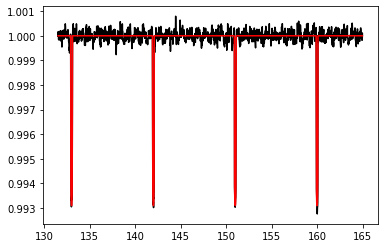

In [38]:
plt.plot(lcinj.time, lcinj.flux, color='k')
plt.plot(lcinj.time, fit_flux, color='r')

Not bad!

If we want to use MCMC to fit our injected transit, we just need to specify the `method` keyword in `.recover_planet`, as well as `nwalkers` and `nsteps`. See this recover_supernova [docstring](https://github.com/ssagear/lightkurve/blob/injrec/lightkurve/lightcurve.py) to check for default settings.

The MCMC method returns an `emcee.EnsembleSampler` object.

In [39]:
%%time
sampler = lcinj.recover_planet(fit_params=['period', 'rprs'], 
            method='mcmc', nwalkers=40, nsteps=1000)


CPU times: user 8.13 s, sys: 82.5 ms, total: 8.21 s
Wall time: 8.64 s


Just for fun, let's plot the burn-in and corner plot.

/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


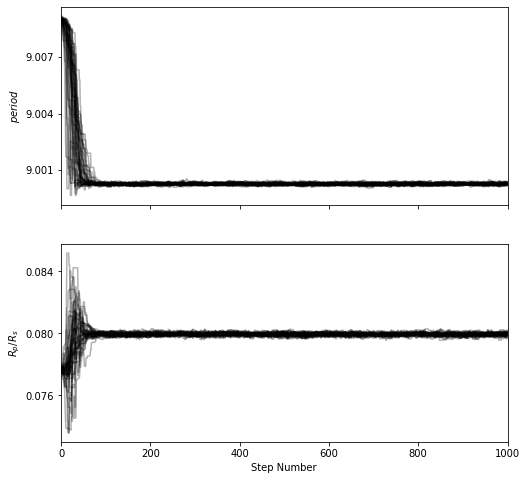

In [40]:
from matplotlib.ticker import MaxNLocator

samples = sampler.chain
labels = ['$period$', '$R_p/R_s$']

fig1 = plt.figure(figsize=[8, 8])
for i in range(samples.shape[-1]):
    ax = fig1.add_subplot(2, 1, i + 1)
    ax.plot(sampler.chain[:, 0:1000, i].T, "k", alpha=0.3)
    ax.set_xlim(0, sampler.chain.shape[1])
    if i < 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("Step Number")
    ax.set_ylabel(labels[i])
    ax.yaxis.set_major_locator(MaxNLocator(4))

    plt.xlim(0, 1000)
fig1.show()

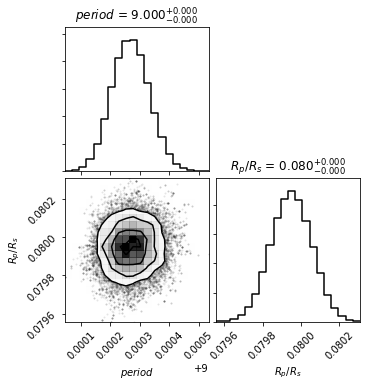

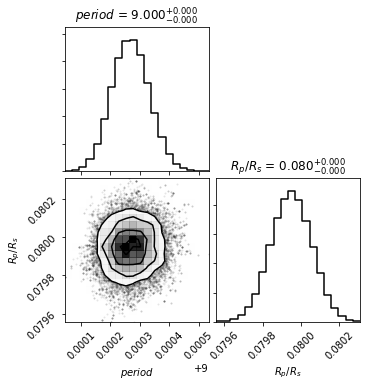

In [41]:
import corner

samples = sampler.chain[:, 200:, :].reshape((-1, 2))

corner.corner(samples[:], labels=["$period$", "$R_p/R_s$"], smooth1d=True,
             show_titles=True, max_n_ticks=5,title_fmt='.3f',color='k')

